In [72]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import math
import statistics
from scipy.stats import norm
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn
import matplotlib.mlab as mlab
import scipy
import datetime as dt

In [73]:
initial_portfolio = 10000

def hour_wiper(df):
    
    df = df.reset_index()
    df["Date"] = pd.to_datetime(df["Date"]).dt.date
    df = df.set_index('Date')
    
    return df

def getData(tickers):
    dict_assets = {}
    dict_returns = {} 
    
    for x in tickers:
        ticker = yf.Ticker(x)
        ticker_data = ticker.history(period = "1y", interval = "1d")
        ticker_data = hour_wiper(ticker_data)
        dict_assets[x] = ticker_data
    
    for x in dict_assets:
        df_common = dict_assets[x]    
        df_common["Returns"] = df_common["Close"].pct_change()
        df_common = df_common.dropna()        
        dict_assets[x] = df_common
       
    for x in dict_assets:
        df_common = dict_assets[x]
        series_returns = df_common["Returns"]
        dict_returns[x] = series_returns
        
    df_returns = pd.concat(dict_returns.values(), axis = 1, keys=dict_returns)   
    df_returns = df_returns.dropna()
    
    meanReturns = df_returns.mean()
    covMatrix = df_returns.cov()
    return df_returns, meanReturns, covMatrix

def weights(df_returns):
    array_weights = np.random.random(len(df_returns.columns))
    array_weights /= np.sum(array_weights)
    
    return array_weights

def Monte_Carlo(initial_portfolio, meanReturns, covMatrix, array_weights):
    mc_sims = 100
    T = 100 #timeframe in days

    meanM = np.full(shape=(T, len(array_weights)), fill_value=meanReturns)
    meanM = meanM.T

    portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

    for m in range(0, mc_sims):
        # MC loops
        Z = np.random.normal(size=(T,len(array_weights)))
        L = np.linalg.cholesky(covMatrix)
        dailyReturns = meanM + np.inner(L, Z)
        portfolio_sims[:,m] = np.cumprod(np.inner(array_weights, dailyReturns.T)+1)*initial_portfolio

    return portfolio_sims

def plot_Monte_Carlo(portfolio_sims):
    plt.plot(portfolio_sims)
    plt.ylabel('Portfolio Value ($)')
    plt.xlabel('Days')
    plt.title('MC simulation of a stock portfolio')
    plt.show
    return

def portfolio_Results(portfolio_sims):
    portfolioResults = pd.Series(portfolio_sims[-1,:])

    return portfolioResults

def mcVaR(returns, initial_portfolio):
    """
    Input: pandas series of returns
    Output: percentile on returns distribution to a given confidence level alpha
    """
    list_alpha = [0.9, 0.95, 0.975, 0.99]
    dict_VaR = {}
    dict_notVaR = {}
    
    if isinstance(returns, pd.Series):
        for x in list_alpha:
            notVaR = np.percentile(returns, (1-x)*100)
            dict_notVaR[x] = notVaR
            dict_VaR[x] = initial_portfolio - notVaR
        display(dict_VaR)
        return dict_notVaR
    else:
        raise TypeError("Expected a pandas data series.")
    
def mcCVaR(returns, dict_notVar, initial_portfolio):
    """
    Input: pandas series of returns
    Output: CVaR or expected shortfall to a given confidence level alpha
    """
    list_alpha = [0.9, 0.95, 0.975, 0.99]
    dict_CVaR = {}

    if isinstance(returns, pd.Series):
        for x in list_alpha:  
            belowVaR = returns <= dict_notVar[x]
            notCVaR = returns[belowVaR].mean()
            CVaR = initial_portfolio - notCVaR
            dict_CVaR[x] = CVaR
        return dict_CVaR
    else:
        raise TypeError("Expected a pandas data series.")

{0.9: 1315.0094134696046,
 0.95: 1722.1626927338566,
 0.975: 2017.5645315999373,
 0.99: 2203.28777166709}

{0.9: 1858.0258379496954,
 0.95: 2143.04530823386,
 0.975: 2314.8600348928167,
 0.99: 2622.1459006933846}

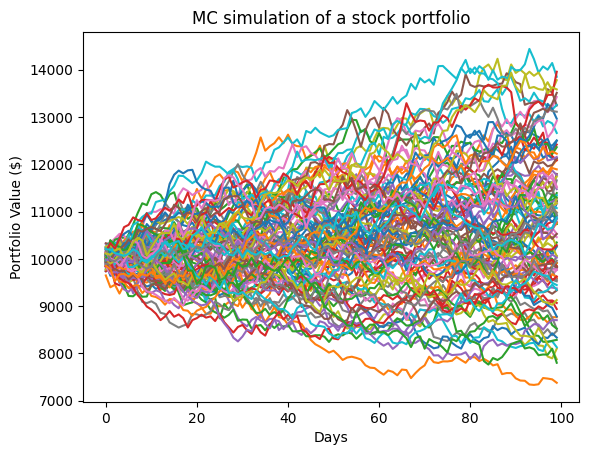

In [74]:
stockList = ['HSBC', 'LYG', 'TSLA']


df_returns, meanReturns, covMatrix = getData(stockList)
array_weights = weights(df_returns)
portfolio_sims = Monte_Carlo(initial_portfolio, meanReturns, covMatrix, array_weights)
plot_Monte_Carlo(portfolio_sims)
portfolioResults = portfolio_Results(portfolio_sims)
dict_notVaR = mcVaR(portfolioResults, initial_portfolio)
CVaR = mcCVaR(portfolioResults, dict_notVaR, initial_portfolio)
display(CVaR)
